In [1]:
# installing java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# downloading apache spark 3.5.3
!wget -q https://dlcdn.apache.org/spark/spark-3.5.3/spark-3.5.3-bin-hadoop3.tgz

# to extract the donwloaded file
!tar xf spark-3.5.3-bin-hadoop3.tgz

# Installing findspark so we can locate Spark
!pip install -q findspark


In [2]:
import os

# setting java environment variable
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

# setting spark environment variable
os.environ["SPARK_HOME"] = "/content/spark-3.5.3-bin-hadoop3"


In [3]:
import findspark
findspark.init()

from pyspark.sql import SparkSession

# creating a soark session
spark = SparkSession.builder \
    .appName("Colab Spark Test") \
    .getOrCreate()

# testing the Spark session by displaying numbers 1-10
spark.range(10).show()


+---+
| id|
+---+
|  0|
|  1|
|  2|
|  3|
|  4|
|  5|
|  6|
|  7|
|  8|
|  9|
+---+



In [4]:
# path of the netflix movies and shows dataset
file_path = '/content/netflix_titles.csv'

In [5]:
# loading the dataset using spark
netflix_df = spark.read.csv(file_path, header=True, inferSchema=True)

# showing the schema
netflix_df.printSchema()

# displaying first 5 rows
netflix_df.show(5)


root
 |-- show_id: string (nullable = true)
 |-- type: string (nullable = true)
 |-- title: string (nullable = true)
 |-- director: string (nullable = true)
 |-- cast: string (nullable = true)
 |-- country: string (nullable = true)
 |-- date_added: string (nullable = true)
 |-- release_year: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- listed_in: string (nullable = true)
 |-- description: string (nullable = true)

+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+--------------------+--------------------+
|show_id|   type|               title|       director|                cast|      country|        date_added|release_year|rating| duration|           listed_in|         description|
+-------+-------+--------------------+---------------+--------------------+-------------+------------------+------------+------+---------+-------------------

In [6]:
print(f"Number of rows: {netflix_df.count()}, Number of columns: {len(netflix_df.columns)}")


Number of rows: 8809, Number of columns: 12


In [7]:
# some statistics for the columns
netflix_df.describe().show()

+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|summary|             show_id|         type|                            title|            director|                cast|         country|     date_added|     release_year|           rating|     duration|           listed_in|         description|
+-------+--------------------+-------------+---------------------------------+--------------------+--------------------+----------------+---------------+-----------------+-----------------+-------------+--------------------+--------------------+
|  count|                8809|         8808|                             8807|                6173|                7983|            7977|           8796|             8807|             8803|         8804|                8806|                8806|
|   mean|       

In [8]:
from pyspark.sql.functions import col, sum

# counting the number of missing values in each column
missing_values = netflix_df.select(
    [(sum(col(c).isNull().cast("int")).alias(c)) for c in netflix_df.columns]
)
missing_values.show()


+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|show_id|type|title|director|cast|country|date_added|release_year|rating|duration|listed_in|description|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+
|      0|   1|    2|    2636| 826|    832|        13|           2|     6|       5|        3|          3|
+-------+----+-----+--------+----+-------+----------+------------+------+--------+---------+-----------+



+-------------+-----+
|         type|count|
+-------------+-----+
|         NULL|    1|
|      TV Show| 2676|
|        Movie| 6131|
|William Wyler|    1|
+-------------+-----+



<Axes: title={'center': 'Content Type Distribution'}, xlabel='type'>

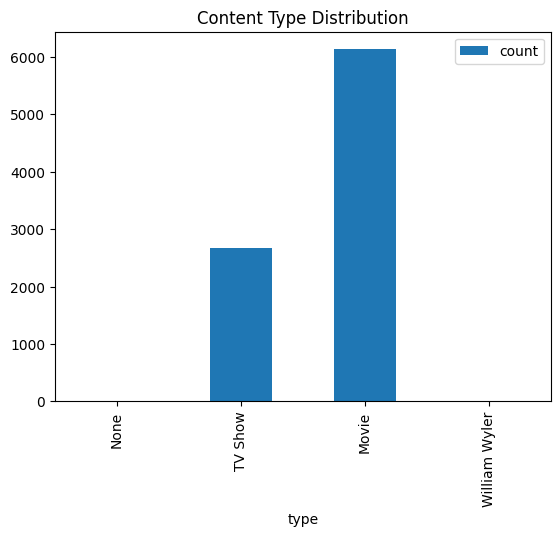

In [13]:
from pyspark.sql.functions import col

# Count the number of Movies and TV Shows
type_distribution = netflix_df.groupBy("type").count()

# Display the results
type_distribution.show()

# Visualization (using matplotlib for plotting)
type_distribution_pd = type_distribution.toPandas()
type_distribution_pd.plot(kind='bar', x='type', y='count', title='Content Type Distribution')


+----------+-----+
|year_added|count|
+----------+-----+
|      NULL|  120|
|      2008|    2|
|      2009|    2|
|      2010|    1|
|      2011|   13|
|      2012|    3|
|      2013|   10|
|      2014|   23|
|      2015|   72|
|      2016|  418|
|      2017| 1162|
|      2018| 1623|
|      2019| 1997|
|      2020| 1872|
|      2021| 1491|
+----------+-----+



<Axes: title={'center': 'Content Added Over Time'}, xlabel='year_added'>

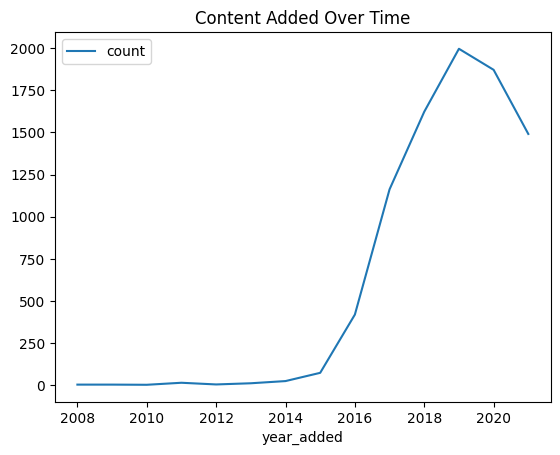

In [14]:
from pyspark.sql.functions import to_date, year

# Convert date_added to date format and extract the year
netflix_df = netflix_df.withColumn("date_added", to_date(col("date_added"), "MMMM d, yyyy"))
netflix_df = netflix_df.withColumn("year_added", year(col("date_added")))

# Count the number of shows added each year
content_added_over_time = netflix_df.groupBy("year_added").count().orderBy("year_added")

# Display the results
content_added_over_time.show()

# Visualization
content_added_over_time_pd = content_added_over_time.toPandas()
content_added_over_time_pd.plot(kind='line', x='year_added', y='count', title='Content Added Over Time')


+--------------------+-----+
|               genre|count|
+--------------------+-----+
| International Mo...| 2622|
|              Dramas| 1595|
|            Comedies| 1206|
|  Action & Adventure|  857|
|       Documentaries|  827|
|              Dramas|  824|
|International TV ...|  774|
|  Independent Movies|  731|
|           TV Dramas|  695|
|     Romantic Movies|  613|
+--------------------+-----+



<Axes: title={'center': 'Top 10 Most Popular Genres'}, xlabel='genre'>

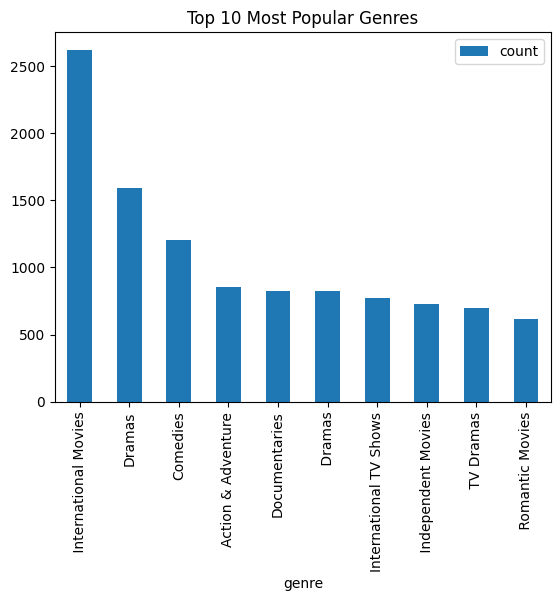

In [15]:
from pyspark.sql.functions import explode, split

# Split the listed_in column into individual genres
genres_df = netflix_df.select(explode(split(col("listed_in"), ",")).alias("genre"))

# Count the occurrences of each genre
genre_counts = genres_df.groupBy("genre").count().orderBy(col("count").desc()).limit(10)

# Display the results
genre_counts.show()

# Visualization
genre_counts_pd = genre_counts.toPandas()
genre_counts_pd.plot(kind='bar', x='genre', y='count', title='Top 10 Most Popular Genres')


+--------------+-----+
|       country|count|
+--------------+-----+
| United States| 2805|
|         India|  972|
|          NULL|  832|
|United Kingdom|  419|
|         Japan|  245|
|   South Korea|  199|
|        Canada|  181|
|         Spain|  145|
|        France|  123|
|        Mexico|  110|
+--------------+-----+



<Axes: title={'center': 'Top 10 Countries Producing Content'}, xlabel='country'>

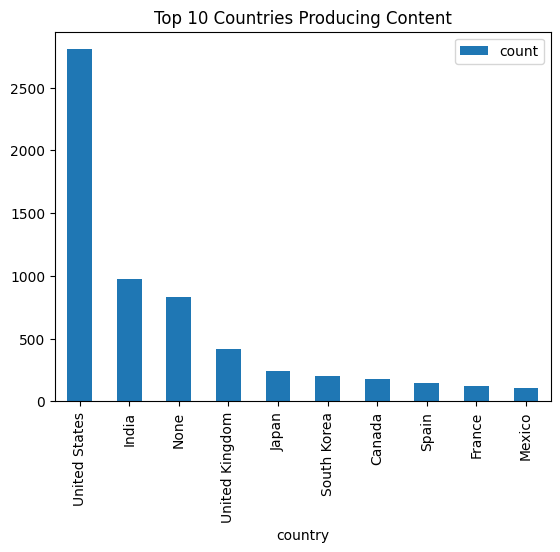

In [16]:
# Count content by country
country_counts = netflix_df.groupBy("country").count().orderBy(col("count").desc()).limit(10)

# Display the results
country_counts.show()

# Visualization
country_counts_pd = country_counts.toPandas()
country_counts_pd.plot(kind='bar', x='country', y='count', title='Top 10 Countries Producing Content')


+---------+-----+
|     word|count|
+---------+-----+
|         |  348|
|     love|  170|
|       my|  144|
|        i|   98|
|      you|   85|
|      man|   81|
|christmas|   78|
|     life|   76|
|    story|   75|
|    movie|   73|
|    world|   70|
|       me|   65|
|   little|   64|
|      one|   63|
|     time|   60|
|     from|   59|
|     last|   59|
|       is|   56|
| american|   53|
|    black|   53|
+---------+-----+



<Axes: title={'center': 'Most Common Words in Titles'}, xlabel='word'>

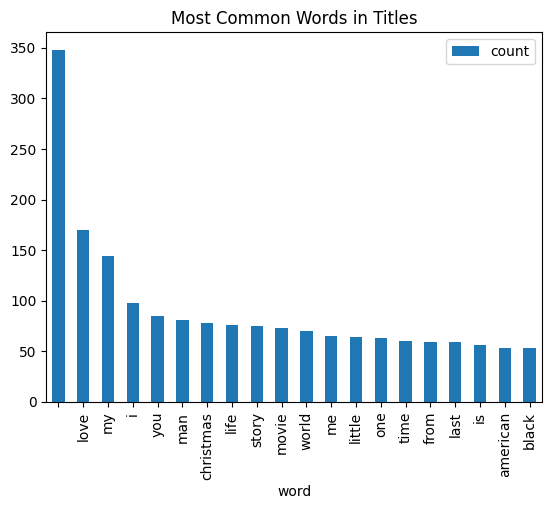

In [17]:
from pyspark.sql.functions import lower, regexp_replace

# Preprocess titles: lowercase and remove punctuation
titles_cleaned = netflix_df.withColumn("cleaned_title", lower(regexp_replace(col("title"), "[^a-zA-Z\s]", "")))

# Split titles into words and explode into individual rows
words_df = titles_cleaned.select(explode(split(col("cleaned_title"), "\s+")).alias("word"))

# Remove stopwords and count word occurrences
stopwords_list = ["a", "an", "the", "and", "of", "in", "to", "with", "on", "for", "at"]  # Add more if needed
words_filtered = words_df.filter(~col("word").isin(stopwords_list))
word_counts = words_filtered.groupBy("word").count().orderBy(col("count").desc()).limit(20)

# Display the results
word_counts.show()

# Visualization
word_counts_pd = word_counts.toPandas()
word_counts_pd.plot(kind='bar', x='word', y='count', title='Most Common Words in Titles')


+-----------------+-----+
|           rating|count|
+-----------------+-----+
|            TV-MA| 3195|
|            TV-14| 2158|
|            TV-PG|  862|
|                R|  796|
|            PG-13|  489|
|            TV-Y7|  334|
|             TV-Y|  307|
|               PG|  286|
|             TV-G|  220|
|               NR|   80|
|                G|   41|
|             NULL|    6|
|         TV-Y7-FV|    6|
|               UR|    3|
|            NC-17|    3|
|             2021|    2|
| November 1, 2020|    1|
| Shavidee Trotter|    1|
|    Adriane Lenox|    1|
|    Maury Chaykin|    1|
+-----------------+-----+
only showing top 20 rows



<Axes: title={'center': 'Content Ratings Distribution'}, xlabel='rating'>

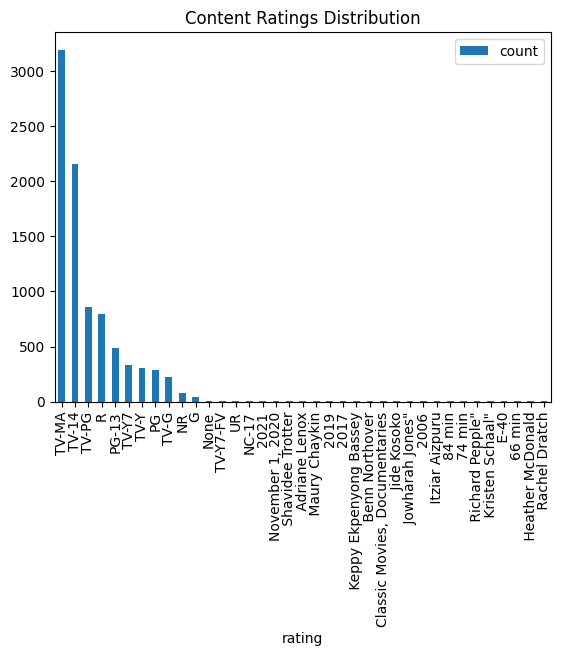

In [18]:
# Count occurrences of each rating
rating_distribution = netflix_df.groupBy("rating").count().orderBy(col("count").desc())

# Display the results
rating_distribution.show()

# Visualization
rating_distribution_pd = rating_distribution.toPandas()
rating_distribution_pd.plot(kind='bar', x='rating', y='count', title='Content Ratings Distribution')


+-------+-----------------+
|summary| numeric_duration|
+-------+-----------------+
|  count|             6113|
|   mean| 99.8750204482251|
| stddev|37.22242934933149|
|    min|                3|
|    max|             1994|
+-------+-----------------+



<Axes: title={'center': 'Distribution of Movie Durations'}, ylabel='Frequency'>

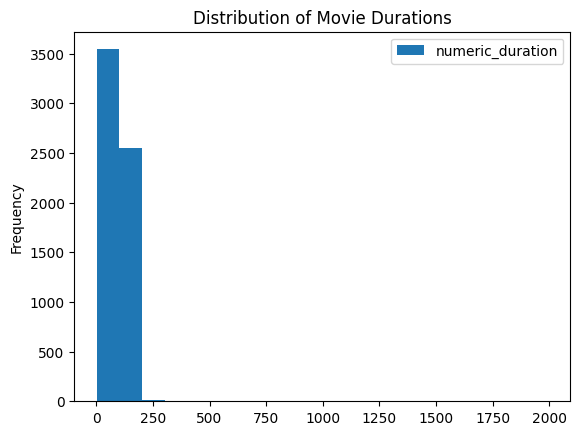

In [19]:
from pyspark.sql.functions import regexp_extract

# Extract numerical duration for movies
duration_df = netflix_df.withColumn("numeric_duration", regexp_extract(col("duration"), "(\d+)", 1).cast("int"))

# Filter for movies only
movies_duration = duration_df.filter(col("type") == "Movie")

# Display the distribution
movies_duration.describe("numeric_duration").show()

# Visualization
movies_duration_pd = movies_duration.select("numeric_duration").toPandas()
movies_duration_pd.plot(kind='hist', bins=20, title='Distribution of Movie Durations')
